In [1]:
import os
import sys

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import numpy as np

from tqdm.notebook import tqdm
import wandb

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from anime_face_generator.config import PROCESSED_DATA_DIR, RAW_DATA_DIR

%load_ext autoreload
%autoreload 2

2025-07-31 01:28:32.418 | INFO     | anime_face_generator.config:<module>:11 - PROJ_ROOT path is: /home/ayoubvip/anime_face_generator


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data augmentation

In [4]:
img_size = (64, 64)
batch_nbr = 16
channels = 3

img_dim=img_size[0] * img_size[1] * channels

In [5]:
transformers = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=img_size),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.RandomResizedCrop(size=img_size, scale=(0.8, 1.0)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    torchvision.transforms.Lambda(lambda x: x.view(-1))  #flattening
])

dataset = torchvision.datasets.ImageFolder(root=PROCESSED_DATA_DIR, transform=transformers, target_transform=None)

In [6]:
rand_gen = torch.Generator().manual_seed(142)

## Architecture

In [32]:

# class SimpleDenoiser(nn.Module):
#     def __init__(self, img_dim):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Linear(img_dim + 1, 512 * 2),
#             nn.ReLU(),
#             nn.Linear(512  * 2, img_dim)
#         )

#     def forward(self, x, t):
#         # Concatenate time step as conditioning
#         t_embed = t.float().unsqueeze(1) / 10.0  # normalize time step
#         t_embed = t_embed.expand(-1, x.shape[1])
#         x_in = torch.cat([x, t_embed], dim=1)
#         return self.model(x_in)

class SimpleDenoiser(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim * 2, 1024),
            nn.ReLU(),
            nn.Linear(1024, img_dim)
        )

    def forward(self, x, t):
        t_embed = t.float().unsqueeze(1) / 10.0
        t_embed = t_embed.expand(-1, x.shape[1])
        x_in = torch.cat([x, t_embed], dim=1)
        return self.model(x_in)


class DiffusionModel(nn.Module):
    def __init__(self, img_dim, timesteps=3):
        super().__init__()
        self.img_dim = img_dim
        self.timesteps = timesteps
        
        betas = torch.tensor([0.0001, 0.001, 0.01])[:timesteps]
        alphas = 1.0 - betas
        alpha_bars = torch.cumprod(alphas, dim=0)
        
        # Register as buffers to move with model.to(device)
        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alpha_bars", alpha_bars)
        
        self.denoiser = SimpleDenoiser(img_dim)

    def q_sample(self, x0, t, noise=None):
        """Sample x_t from q(x_t | x_0)"""
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_ab = self.alpha_bars[t].sqrt().unsqueeze(1)
        sqrt_1m_ab = (1 - self.alpha_bars[t]).sqrt().unsqueeze(1)
        return sqrt_ab * x0 + sqrt_1m_ab * noise

    def p_losses(self, x0, t):
        """Train to predict noise"""
        noise = torch.randn_like(x0)
        x_t = self.q_sample(x0, t, noise)
        noise_pred = self.denoiser(x_t, t)
        return F.mse_loss(noise_pred, noise)

    def forward(self, x0):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.timesteps, (batch_size,), device=x0.device)
        return self.p_losses(x0, t)

In [9]:
@torch.no_grad()
def sample(model, img_dim, num_samples=16):
    x_t = torch.randn(num_samples, img_dim).to(next(model.parameters()).device)
    for t in reversed(range(model.timesteps)):
        t_tensor = torch.full((num_samples,), t, device=x_t.device)
        noise_pred = model.denoiser(x_t, t_tensor)
        beta = model.betas[t]
        alpha = model.alphas[t]
        alpha_bar = model.alpha_bars[t]

        if t > 0:
            noise = torch.randn_like(x_t)
        else:
            noise = 0

        x_t = (1 / torch.sqrt(alpha)) * (x_t - (1 - alpha) / torch.sqrt(1 - alpha_bar) * noise_pred) + torch.sqrt(beta) * noise
    return x_t


In [10]:


model = DiffusionModel(img_dim=img_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dataloader = tdata.DataLoader(
    dataset=dataset,
    batch_size=batch_nbr,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
# Training loop
for epoch in tqdm(range(30)):
    for x, _ in dataloader:
        x = x.to(device)
        loss = model(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}: loss={loss.item():.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Simpling from the learned distribution

In [43]:
import matplotlib.pyplot as plt

@torch.no_grad()
def sample_images_grid(model, img_size=64, num_rows=8, num_cols=6):
    model.eval()
    num_samples = num_rows * num_cols
    img_dim = img_size * img_size * 3

    # Sample flat images (B, 12288)
    samples = sample(model, img_dim=img_dim, num_samples=num_samples)
    
    # Reshape to (B, C, H, W) for RGB image display
    samples = samples.view(num_samples, 3, img_size, img_size).cpu().clamp(0, 1)
    
    # Plot in a grid
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 1.5, num_rows * 1.5))
    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            axs[i, j].imshow(samples[idx].permute(1, 2, 0))  # CHW → HWC
            axs[i, j].axis("off")
    plt.tight_layout()
    plt.show()


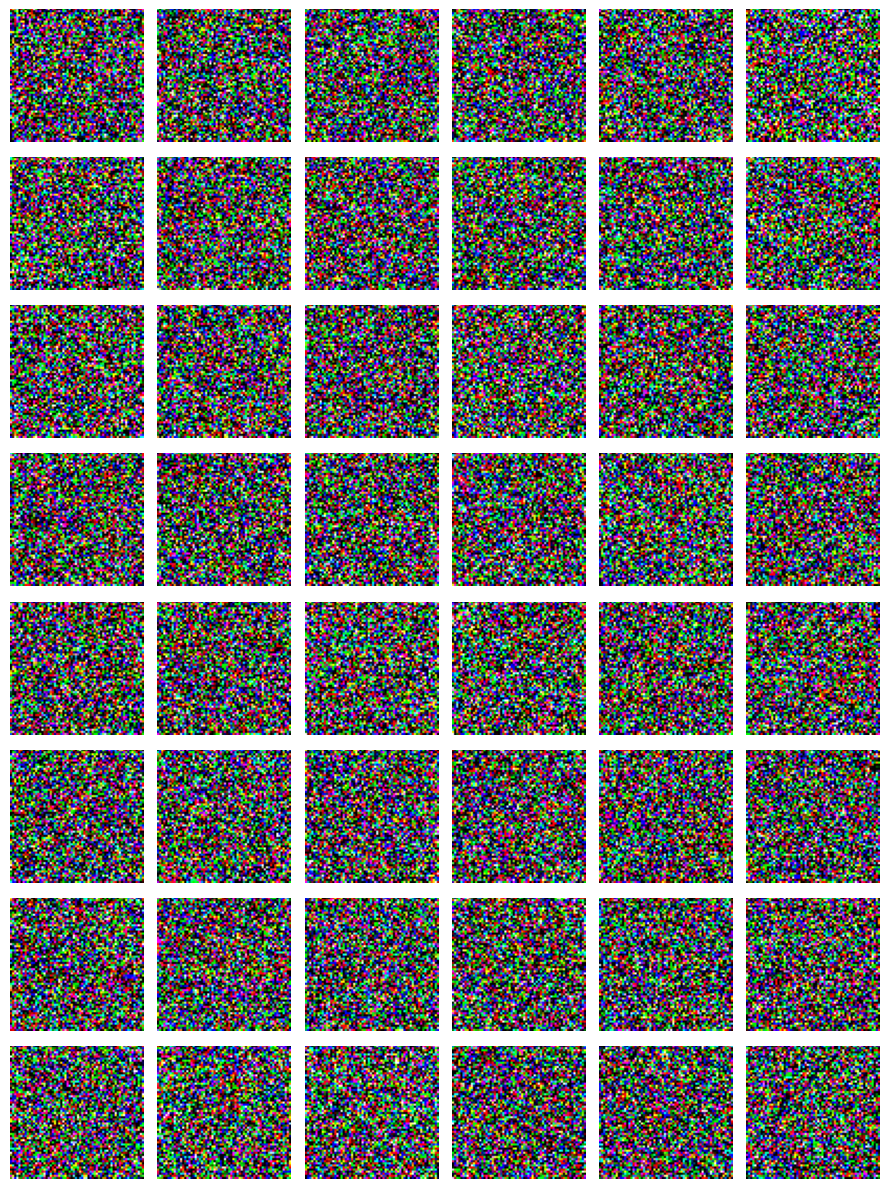

In [44]:
sample_images_grid(model, img_size=64, num_rows=8, num_cols=6)

In [7]:
import time
correct = "none"
model_name = f"{correct}--" + time.strftime("%Y-%m-%d_%H-%M-%S") + "_VDM_model.pth"
torch.save(model.state_dict(), MODELS_DIR / model_name)
print("Saved PyTorch Model State to " +  model_name)

NameError: name 'model' is not defined

 ### Saving the notebook.

In [ ]:
# %%javascript
# IPython.notebook.save_notebook()
from ipylab import JupyterFrontEnd
app = JupyterFrontEnd()
app.commands.execute('docmanager:save')